# benchmarking on sergio


In [23]:
from bengrn import BenGRN
import scanpy as sc
from scprint import scPrint

from scdataloader import Preprocessor

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils
from grnndata import read_h5ad
import numpy as np
import pandas as pd

from scprint.tasks import GNInfer

import anndata as ad
from scipy.sparse import csr_matrix

from scdataloader import utils as data_utils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

# preprocess

In [3]:
adata = read_h5ad("../tools/SERGIO/sergio_gt_grn.h5ad")
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
genesdf = data_utils.load_genes(adata.obs.organism_ontology_term_id.iloc[0])
adata

GRnnData object with n_obs × n_vars = 1000 × 813
    obs: 'organism_ontology_term_id'
    varp: 'GRN'
    with a grn of 3546 elements

In [4]:
# Merge adata.var with genesdf
# First, ensure the index of adata.var is named
adata.var.index.name = 'symbol'

# Merge adata.var with genesdf
# Merge adata.var with genesdf, keeping only the first instance of each symbol
merged_var = adata.var.reset_index().merge(
    genesdf.reset_index().drop_duplicates(subset='symbol', keep='first'),
    left_on='symbol',
    right_on='symbol',
    how='left'
)

# Set the index back to 'symbol'
merged_var.set_index('symbol', inplace=True)
adata.var = merged_var
adata.var['symbol'] =  adata.var.index

In [5]:
subadata = adata[:, adata.var.ensembl_gene_id.isin(genes)].copy()
del subadata.varp['GRN']

In [12]:
subadata.var['symbol'] = subadata.var.index
subadata.var.index = subadata.var.ensembl_gene_id

In [17]:
intersect_genes = set(subadata.var.index).intersection(set(genesdf.index))
subadata = subadata[:, list(intersect_genes)]
# marking unseen genes
unseen = set(genesdf.index) - set(subadata.var.index)
# adding them to subadata
emptyda = ad.AnnData(
    csr_matrix((subadata.shape[0], len(unseen)), dtype=np.float32),
    var=pd.DataFrame(index=list(unseen)),
    obs=pd.DataFrame(index=subadata.obs.index),
)
subadata = ad.concat([subadata, emptyda], axis=1, join="outer", merge="only")
# do a validation function
subadata = subadata[:, subadata.var.sort_index().index]


In [19]:
subadata = subadata.copy()

In [20]:
subadata

AnnData object with n_obs × n_vars = 1000 × 70933
    obs: 'organism_ontology_term_id'
    var: 'ensembl_gene_id', 'uid', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'symbol'

# run

In [22]:
model = scPrint.load_from_checkpoint(
 #   '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)
#    '../data/temp/wli32e2j/last.ckpt', precpt_gene_emb=None)
#    '../data/temp/vbd8bavn/epoch=17-step=90000.ckpt', precpt_gene_emb=None)
#    '../data/temp/25eer0xz/epoch=20-step=105000.ckpt', precpt_gene_emb=None)
NUM_GENES = 5000
NUM_CELLS = 1024
metrics = {}

RuntimeError caught: scPrint is not attached to a `Trainer`.


In [47]:
grn_inferer = GNInfer(layer=list(range(model.nlayers))[:],
                     how="most var within",
                     preprocess="softmax",
                     head_agg='mean',
                     filtration="none",
                     forward_mode="none",
                     num_genes=1000,
                     max_cells=1000,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(model, subadata,)

number of expressed genes in this cell type: 797


100%|██████████| 32/32 [00:21<00:00,  1.51it/s]


avg link count: 948676, sparsity: 1.0


precision:  0.03245252403279214 
recall:  1.0 
random precision: 0.0324932935353459


  0%|          | 0/128 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 4011.95it/s]

Average Precision (AP):  0.0412594987004315
Area Under Precision-Recall Curve (AUPRC):  0.041148013575227765
EPR: 1.8367178615435387


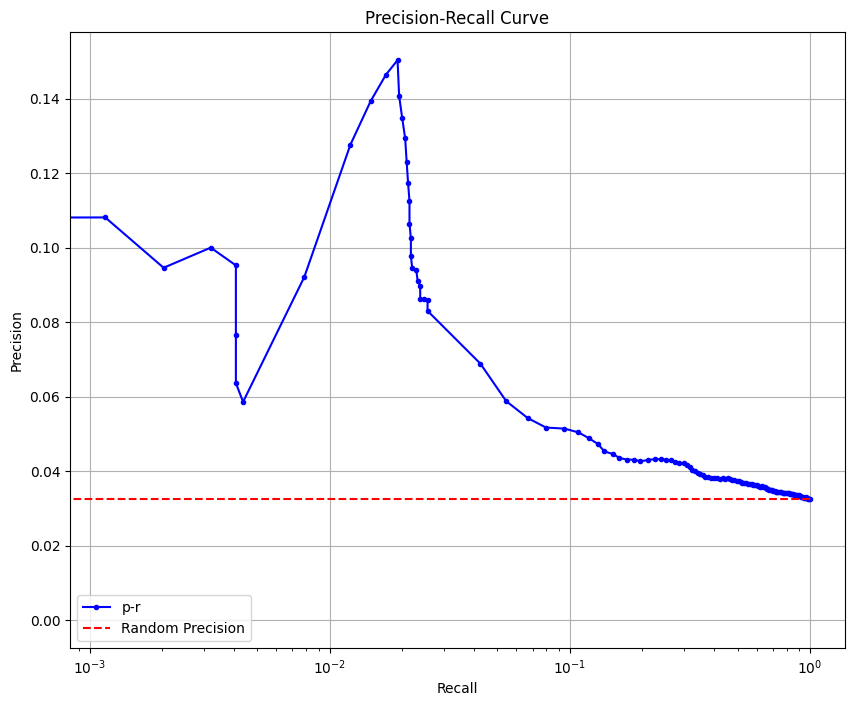

{'precision': 0.03245252403279214,
 'recall': 1.0,
 'rand_precision': 0.0324932935353459,
 'auprc': 0.041148013575227765,
 'ap': 0.0412594987004315,
 'epr': 1.8367178615435387}

In [48]:
# normal
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


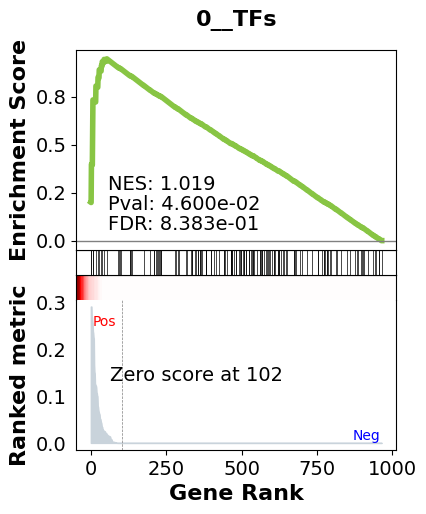

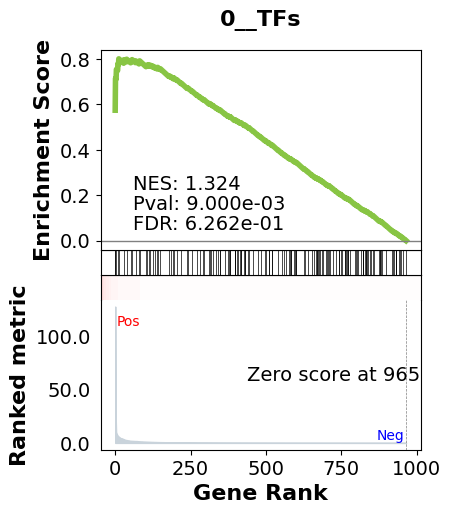

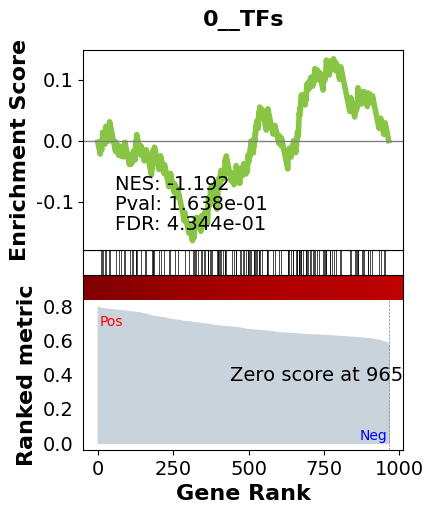

_________________________________________
TF specific enrichment
found some significant results for  13.157894736842104 % TFs

_________________________________________
loading GT,  omnipath
intersection of 652 genes
intersection pct: 0.6749482401656315
precision:  0.02469513342617336 
recall:  1.0 
random precision: 0.024733067578901737


 61%|██████    | 78/128 [00:00<00:00, 776.04it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 780.96it/s]


Average Precision (AP):  0.027587770748954663
Area Under Precision-Recall Curve (AUPRC):  0.027595000968797558
EPR: 1.7393345120321586


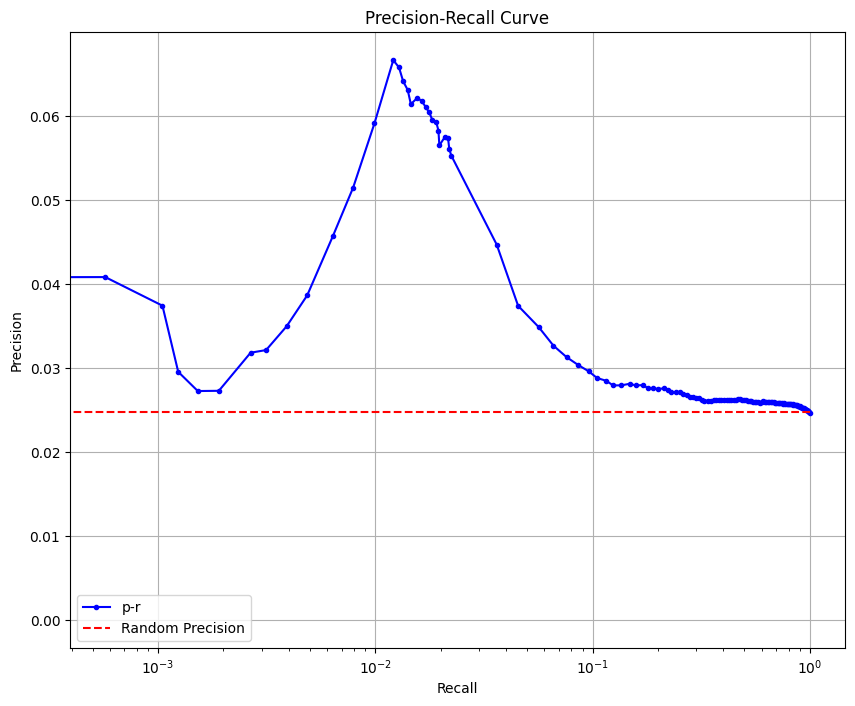

{'TF_enr': False,
 'significant_enriched_TFtargets': 13.157894736842104,
 'precision': 0.02469513342617336,
 'recall': 1.0,
 'rand_precision': 0.024733067578901737,
 'auprc': 0.027595000968797558,
 'ap': 0.027587770748954663,
 'epr': 1.7393345120321586}

In [49]:
BenGRN(grn).scprint_benchmark()